In [1]:
import numpy as np

prob = {}
prob['rov_T'] = 15
prob['cop_T'] = 30
prob['rov_x0'] = np.array([0.5, -4.5])
prob['cop_x0'] = np.array([-0.5, -4.5, 2])
prob['cop_xT'] = np.array([1.5, -1.5, 2])
prob['cop_sight'] = 2.6
prob['prob_margin'] = 0.05

In [2]:
import polytope as pc
from collections import OrderedDict

from best.abstraction import Abstraction
from best.mdp import ParallelMDP
import best.rss18_functions as rf

# regions
regs = OrderedDict()

regs['r1'] = (pc.box2poly(np.array([[2, 3], [0, 5]])), 0.5, 'red')
regs['r2'] = (pc.box2poly(np.array([[-3, -2], [0, 5]])), 0.5, 'red')
regs['a1'] = (pc.box2poly(np.array([[-1, 1], [4, 5]])), 0.5, 'green')
regs['b1'] = (pc.box2poly(np.array([[4, 5], [4, 5]])), 0.5, 'blue')
regs['c1'] = (pc.box2poly(np.array([[-5, -4], [4, 5]])), 0.5, 'blue')

e_init = [0 if  reg[1] in [0,1] else 2 for reg in regs.itervalues()]

prob['regs'] = regs
prob['env_x0'] = e_init

# formula
prob['formula'] = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( emptyA & sampleC ) )'

# rover model
rover_abstr = Abstraction([-5, -5], [5, 5], [10, 10])
rover = rover_abstr.abstract()
rover.input_name = 'ar'
rover.output_name = 'xr'
print rover

# copter model
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2])
copter = copter_abstr.abstract()
copter.input_name = 'ac'
copter.output_name = 'xc'
print copter

# Environment belief model
env = ParallelMDP([rf.get_mdp(info[1], 0, name) for (name, info) in regs.iteritems()])
print env

# connect rover-env
rover_env_mdp = rover.product(env, connection=rf.get_conn_rov_env(prob['regs']) )
print rover_env_mdp

# Connect copter-env
mdp_copt_env = copter.product(env, connection=rf.get_conn_copt_env(prob['regs'], prob['cop_sight']) )

Using numpy backend.


MDP: 5 inputs "ar" --> 100 outputs "xr"
MDP: 7 inputs "ac" --> 200 outputs "xc"
MDP: 243 inputs "(r1_u, r2_u, a1_u, b1_u, c1_u)" --> 3125 outputs "(r1_b, r2_b, a1_b, b1_b, c1_b)"
MDP: 5 inputs "ar" --> 312500 outputs "(xr, (r1_b, r2_b, a1_b, b1_b, c1_b))"


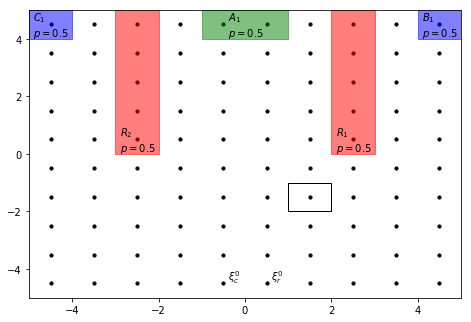

In [3]:
# plot regions

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abstr.plot(ax)

for name, info in regs.iteritems():
    rf.plot_region(ax, info[0], name, info[1], info[2])
    
ax.text(prob['rov_x0'][0]+0.1, prob['rov_x0'][1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle(  prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))
ax.text( prob['cop_x0'][0]+0.1, prob['cop_x0'] [1]+0.1, '$\\xi_c^0$')

fig.savefig('arena.pdf')

In [4]:
# solve rover LTL problem

from best.ltl import solve_ltl_cosafe

rover_ltlpol = solve_ltl_cosafe(rover_env_mdp, prob['formula'], rf.get_ltl_connection(regs),
                                delta=0.001, maxiter=prob['rov_T'], verbose=True)

# construct copter value fcn
VT = -np.inf * np.ones(mdp_copt_env.N_list)

init_rov = rover_abstr.x_to_s(prob['rov_x0'])
init_dfsa = rover_ltlpol.dfsa_init

v_max = np.max(rover_ltlpol.V.flatten())

end_cop = copter_abstr.x_to_s(prob['cop_xT'])

idx = np.logical_or(rover_ltlpol.V[init_rov, :, init_dfsa] > v_max-prob['prob_margin'],
                    rover_ltlpol.V[init_rov, :, init_dfsa] < prob['prob_margin'])

VT[end_cop, :] = 0
VT[end_cop, idx] = 1
            
# solve copter reach problem
V_copt, Pol_copt = mdp_copt_env.solve_reach(VT, maxiter=prob['cop_T'], delta=0.001, verbose=True)

iteration 0, time 6.79492950439e-05
iteration 1, time 4.87564706802
iteration 2, time 9.48280286789
iteration 3, time 13.1120109558
iteration 4, time 16.7162790298
iteration 5, time 20.1441590786
iteration 6, time 23.5941650867
iteration 7, time 27.012116909
iteration 8, time 30.4749400616
iteration 9, time 33.8786768913
iteration 10, time 37.3297450542
iteration 11, time 40.7308158875
iteration 12, time 44.2492730618
iteration 13, time 47.6498298645
iteration 14, time 51.0975699425
finished after 54.5215089321s and 15 iterations
iteration 0, time 0.000273942947388
iteration 1, time 1.07809996605
iteration 2, time 2.15308094025
iteration 3, time 3.2144920826
iteration 4, time 4.28331208229
iteration 5, time 5.34470796585
iteration 6, time 6.40841388702
iteration 7, time 7.50106906891
iteration 8, time 8.55976486206
iteration 9, time 9.62745189667
iteration 10, time 10.6988639832
iteration 11, time 11.7659008503
iteration 12, time 12.8392848969
iteration 13, time 13.907859087
iteration 

In [5]:
# save controllers
import cPickle as pickle

copter_policy = rf.CopterPolicy(Pol_copt, V_copt, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)

with open('policies.pickle', 'wb') as fp:
  pickle.dump((copter_policy, rover_policy, prob), fp)

success probability: 0.241000041366


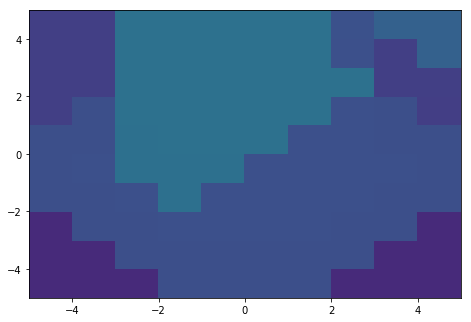

In [6]:
# plot rover value fcn
def my_value(x, mapstate):    
    s_abstr = rover_abstr.x_to_s(x)
    s_map = env.global_state(mapstate)

    _, val = rover_ltlpol.get_input((s_abstr, s_map))
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), prob['env_x0'])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print 'success probability: {}'.format(my_value(prob['rov_x0'], prob['env_x0']))

fig.savefig('value-rov.pdf')

success value: 0.977000296116


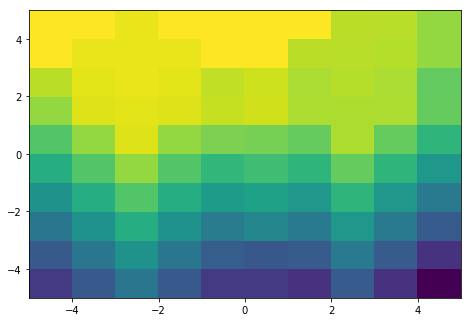

In [7]:
# plot copter value fcn
map_init = env.global_state(prob['env_x0'])

def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    
    return V_copt[scop, mapstate]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), map_init)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print 'success value: {}'.format(copter_value(prob['cop_x0'], map_init))